In [85]:
import logging
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from collections import defaultdict
import math
from pathlib import Path

In [86]:
PROJECT_ROOT = "../"
INTERMEDIATE_OUTPUT_DIR = PROJECT_ROOT + 'output/' + 'intermediate_data/'
# 入力ファイルパス

# 出力ファイルパス
RISK_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'risk_gdf.pkl'
SYURAKU_WITH_ISOLATION_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'syuraku_with_isolation_gdf.pkl'
SYURAKU_POP_RISK_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'syuraku_pop_risk_gdf.pkl'

OPTIMIZATION_VARS_NPZ = INTERMEDIATE_OUTPUT_DIR + 'optimization_vars.npz'
FACILITY_NODE_PKL = INTERMEDIATE_OUTPUT_DIR + 'facility.pkl'
DESTINATION_NODE_PKL = INTERMEDIATE_OUTPUT_DIR + 'destination.pkl'

FINAL_OUTPUT_DIR = PROJECT_ROOT + 'output/' + 'final_results/'
OPTIMIZATION_RESULTS_PKL = FINAL_OUTPUT_DIR + 'optimization_results.pkl'

In [87]:
# --- データ読み込み ---
def load_data_for_viz(results_path: Path,params_path, *args) -> dict:
    """可視化に必要なすべてのファイルを読み込む。"""
    logging.info("Loading data for visualization...")
    try:
        data = {'results_df': pd.read_pickle(results_path)}
        params_np= np.load(params_path, allow_pickle=True)
        data['params'] = {key: params_np[key] for key in params_np.files}
        for path in args:
            data[Path(path).stem] = pd.read_pickle(path)
        return data
    except FileNotFoundError as e:
        logging.error(f"Error: Input file not found: {e.filename}")
        logging.error("Please run '01_prepare_data.py' and '02_run_optimization.py' first.")
        exit()

In [88]:
data = load_data_for_viz(
        OPTIMIZATION_RESULTS_PKL,
        OPTIMIZATION_VARS_NPZ,
        FACILITY_NODE_PKL,
        DESTINATION_NODE_PKL,
        SYURAKU_POP_RISK_GDF_PKL
    )

In [89]:
# --- 可視化関数 ---
def find_pareto_and_knee(results_df: pd.DataFrame):
    """
    与えられた結果からパレート最適解と膝（妥協解）を特定する。
    """
    if results_df.empty:
        return pd.DataFrame(), None

    # (未カバーリスク, 総収益) のタプルリストを作成
    points = list(zip(results_df['uncovered_risk'], results_df['total_profit']))
    
    # パレート最適解をフィルタリング
    pareto_points = []
    for p1 in points:
        is_dominated = False
        for p2 in points:
            if p1 == p2: continue
            # p2がp1を支配する条件: p2のリスクが同じか低く、p2の収益が同じか高い
            if p2[0] <= p1[0] and p2[1] >= p1[1]:
                is_dominated = True
                break
        if not is_dominated:
            pareto_points.append(p1)

    pareto_df = pd.DataFrame(pareto_points, columns=['risk', 'profit']).drop_duplicates().sort_values(by='risk')
    
    if len(pareto_df) < 2:
        return pareto_df, None # 膝を特定するには点が2つ以上必要

    # --- 膝（Knee Point）の特定 ---
    # 理想点（リスク最小、収益最大）からの正規化距離で評価
    risk_norm = (pareto_df['risk'] - pareto_df['risk'].min()) / (pareto_df['risk'].max() - pareto_df['risk'].min())
    profit_norm = (pareto_df['profit'] - pareto_df['profit'].min()) / (pareto_df['profit'].max() - pareto_df['profit'].min())
    
    # 理想点は(0, 1)
    distances = np.sqrt(risk_norm**2 + (1 - profit_norm)**2)
    knee_index = distances.idxmin()
    knee_point = pareto_df.loc[knee_index]
    
    return pareto_df, knee_point

In [90]:
def find_pareto_and_knee(results_df: pd.DataFrame, base_params: dict):
    """与えられた結果からパレート最適解と膝（妥協解）を特定する。"""
    if results_df.empty:
        return pd.DataFrame(), None

    # 未カバーリスクを計算
    max_risk = base_params['MAX_SUM_UNCOVERED_ISOLATED_PEOPLE']
    results_df['uncovered_risk'] = max_risk - results_df['covered_risk']
    
    pareto_df = results_df.sort_values(by='uncovered_risk').drop_duplicates(subset=['uncovered_risk', 'total_profit'])

    if len(pareto_df) < 2:
        return pareto_df, None 

    # 膝（Knee Point）の特定
    risk_range = pareto_df['uncovered_risk'].max() - pareto_df['uncovered_risk'].min()
    profit_range = pareto_df['total_profit'].max() - pareto_df['total_profit'].min()
    if risk_range == 0 or profit_range == 0: return pareto_df, None

    risk_norm = (pareto_df['uncovered_risk'] - pareto_df['uncovered_risk'].min()) / risk_range
    profit_norm = (pareto_df['total_profit'] - pareto_df['total_profit'].min()) / profit_range
    
    distances = np.sqrt(risk_norm**2 + (1 - profit_norm)**2)
    knee_index = distances.idxmin()
    knee_point = pareto_df.loc[knee_index]
    
    return pareto_df, knee_point

In [91]:

def plot_pareto_frontier(results_df: pd.DataFrame):
    """パレートフロンティアと妥協解をプロットする。"""
    logging.info("Plotting Pareto frontier...")
    
    pareto_df, knee_point = find_pareto_and_knee(results_df)

    if pareto_df.empty:
        logging.warning("No Pareto points to plot.")
        return

    fig, ax = plt.subplots(figsize=(10, 7))
    
    # パレートフロンティアをプロット
    ax.plot(pareto_df['risk'], pareto_df['profit'], marker='o', linestyle='-', label='Pareto Frontier')

    # 各点をomega値で注釈
    for _, row in results_df.iterrows():
        ax.annotate(f"ω_p={row['omega_profit']:.2f}", 
                    (row['uncovered_risk'], row['total_profit']),
                    textcoords="offset points",
                    xytext=(5, -15),
                    ha='left',
                    fontsize=9,
                    alpha=0.8)

    # 膝の点をハイライト
    if knee_point is not None:
        ax.scatter(knee_point['risk'], knee_point['profit'], color='red', marker='*', s=200, zorder=5, label='Compromise Solution (Knee)')
        logging.info(f"Compromise solution (Knee): Risk={knee_point['risk']:.2f}, Profit={knee_point['profit']:,.0f}")

    ax.set_title('Trade-off between Profitability and Risk Reduction', fontsize=16)
    ax.set_xlabel('Expected Affected Population (Uncovered) [persons]', fontsize=12)
    ax.set_ylabel('Total Profit [JPY]', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    # Y軸のラベルを指数表記から通常表記へ
    ax.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.show()

In [92]:
from adjustText import adjust_text

def plot_pareto_frontier(results_df: pd.DataFrame, base_params: dict):
    """パレートフロンティアと妥協解をプロットする。近接する点の注釈はグループ化する。"""
    logging.info("Plotting Pareto frontier with grouped annotations...")

    if results_df.empty:
        logging.warning("No results to plot.")
        return

    # --- グループ化ロジック ---
    grouped_points = defaultdict(list)
    tolerance = 1e-3
    
    # 未カバーリスクを計算
    max_risk = base_params['MAX_SUM_UNCOVERED_ISOLATED_PEOPLE']
    results_df['uncovered_risk'] = max_risk - results_df['covered_risk']
    
    # (risk, profit)でソート
    sorted_df = results_df.sort_values(by=['uncovered_risk', 'total_profit'])

    if sorted_df.empty: return

    # 最初の点を基準にグループ化を開始
    current_group_key = (sorted_df.iloc[0]['uncovered_risk'], sorted_df.iloc[0]['total_profit'])
    for _, row in sorted_df.iterrows():
        risk, profit, omega = row['uncovered_risk'], row['total_profit'], row['omega_profit']
        if math.isclose(risk, current_group_key[0], rel_tol=tolerance, abs_tol=tolerance) and \
           math.isclose(profit, current_group_key[1], rel_tol=tolerance, abs_tol=tolerance):
            grouped_points[current_group_key].append(omega)
        else:
            current_group_key = (risk, profit)
            grouped_points[current_group_key].append(omega)

    # --- 描画データの準備 ---
    pareto_df, knee_point = find_pareto_and_knee(results_df, base_params)

    # --- グラフ描画 ---
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(pareto_df['uncovered_risk'], pareto_df['total_profit'], marker='o', linestyle='-', color='blue', label='Pareto Frontier')
    
    # 【変更点2】注釈オブジェクトを保存するためのリストを作成
    texts = []

    # グループ化された注釈
    for (risk_val, profit_val), omega_list in grouped_points.items():
        print(f"Risk: {risk_val}, Profit: {profit_val}, Omegas: {omega_list}")
        if len(omega_list) == 1:
            label_text = fr'$\omega_{{prof}}={omega_list[0]:.2f}$'
        else:
            omega_str = ", ".join([f"{w:.2f}" for w in sorted(omega_list)])
            label_text = fr'$\omega_{{prof}} \in \{{{omega_str}\}}$'

        # 【変更点3】ax.annotateの代わりに、textオブジェクトをリストに追加
        # ここではax.textを使い、後でまとめて調整します
        texts.append(ax.text(risk_val, profit_val, label_text, fontsize=11))
    
    # 【変更点4】adjust_textを呼び出して、ラベルの位置を自動調整
    # arrowpropsで点とラベルを線で結び、見やすくします
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))


    # 膝の点を強調表示
    if knee_point is not None:
        # 膝の点に対応するomega値を取得
        knee_omegas = grouped_points.get((knee_point['uncovered_risk'], knee_point['total_profit']), [])
        knee_omegas_str = ", ".join([f"{w:.2f}" for w in sorted(knee_omegas)])
        label = fr'Compromise Solution ($\omega_{{prof}} \in \{{{knee_omegas_str}\}}$)'
        ax.scatter(knee_point['uncovered_risk'], knee_point['total_profit'], color='red', marker='*', s=250, zorder=5, label=label)
        logging.info(f"Compromise solution (Knee): Risk={knee_point['uncovered_risk']:.2f}, Profit={knee_point['total_profit']:,.0f}")

    ax.set_title(r'Trade-off between Profitability and Risk Reduction', fontsize=16)
    ax.set_xlabel('Expected Affected Population (Uncovered) [persons]', fontsize=12)
    ax.set_ylabel('Total Profit [JPY]', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.ticklabel_format(style='plain', axis='y')
    fig.tight_layout()
    plt.show()

Risk: 2187.2527987238627, Profit: 138681539.6743127, Omegas: [0.01, 0.0]
Risk: 2240.0087078425313, Profit: 199115150.2603742, Omegas: [0.05]
Risk: 2361.0857608140886, Profit: 236102664.55262297, Omegas: [0.1]
Risk: 2457.2081286894263, Profit: 246388103.18720028, Omegas: [0.3, 0.2]
Risk: 2702.5927910011833, Profit: 258471147.3951799, Omegas: [0.7, 0.6, 0.5, 0.4]
Risk: 2978.6647487054997, Profit: 260260284.0457811, Omegas: [0.9, 0.8]
Risk: 3177.87129973057, Profit: 260530614.550596, Omegas: [0.99, 0.95]
Risk: 4056.9371612180876, Profit: 260643866.79573792, Omegas: [1.0]


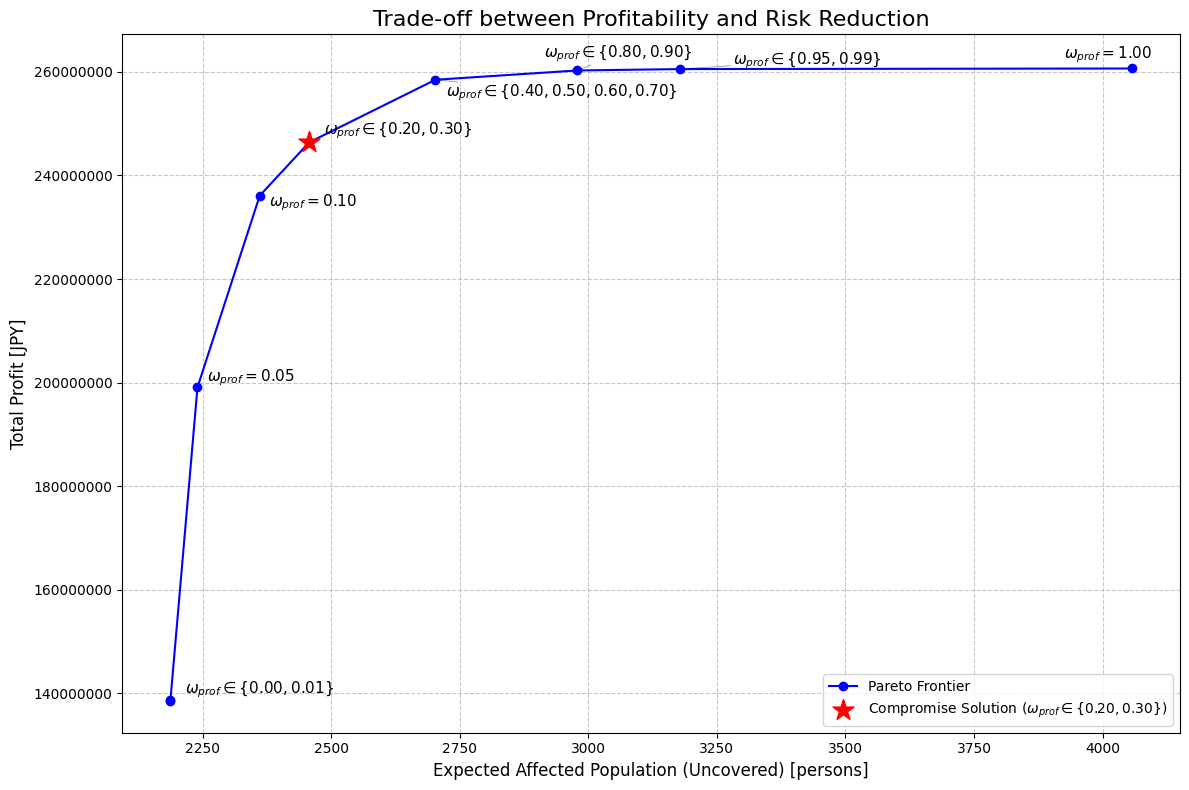

In [93]:
plot_pareto_frontier(data['results_df'], data['params'])

In [94]:
import cmasher as cmr
import matplotlib
from matplotlib.patches import Patch # 👈 これを追加


In [95]:
# --- 定数定義 ---
# パス設定
PROJECT_ROOT = "../"
DATA_DIR = PROJECT_ROOT + 'data/'
OUTPUT_DIR = PROJECT_ROOT + 'output/'
INTERMEDIATE_OUTPUT_DIR = OUTPUT_DIR + 'intermediate_data/'

# 入力データパス
AGRI_DIR = DATA_DIR + 'agricultural_settlements/'
DEM_DIR = DATA_DIR  + 'DEM250/'
PGV_DIR = DATA_DIR + 'jshis_pgv/'
POP_DIR = DATA_DIR + 'population/'
MESH_DIR = DATA_DIR + 'mesh/'

# 座標参照系 (CRS)
TARGET_CRS = "EPSG:4612"
WGS84_CRS = "EPSG:4326" # 緯度経度計算用のCRS

# 出力ファイルパス
AGRI_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'agri_gdf.pkl'
DEM_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'dem_gdf.pkl'
PGV_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'pgv_gdf.pkl'
ROAD_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'road_gdf.pkl'

In [96]:
import pickle

with open(AGRI_GDF_PKL, 'rb') as file:
    agri_gdf = pickle.load(file)

with open(PGV_GDF_PKL, 'rb') as file:
    pgv_gdf = pickle.load(file)

with open(DEM_GDF_PKL, 'rb') as file:
    dem_gdf = pickle.load(file)

with open(ROAD_GDF_PKL, 'rb') as file:
    road_gdf = pickle.load(file)


In [97]:
# 出力ファイルパス
RISK_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'risk_gdf.pkl'
SYURAKU_WITH_ISOLATION_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'syuraku_with_isolation_gdf.pkl'
SYURAKU_POP_RISK_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'syuraku_pop_risk_gdf.pkl'
with open(RISK_GDF_PKL, 'rb') as file:
    risk_gdf = pickle.load(file)

with open(SYURAKU_WITH_ISOLATION_GDF_PKL, 'rb') as file:
    syuraku_with_isolation_gdf = pickle.load(file)

with open(SYURAKU_POP_RISK_GDF_PKL, 'rb') as file:
    syuraku_pop_risk_gdf = pickle.load(file)

In [141]:
def plot_detailed_background_map(ax, data: dict,font_size):
    """
    標高、道路、人口、孤立リスクなどの詳細な背景地図を指定されたAxesにプロットする。
    凡例ハンドルのうち、サイズに関する部分を返す。
    """
    # 凡例で使用する定数
    min_marker_size = 10
    max_marker_size = 300
    # 1. すべてのポリゴンを結合するための共通キーを持つ列を追加します
    agri_gdf['dissolve_key'] = 1

    # 2. 'dissolve_key'列を基準にポリゴンを統合（ディゾルブ）します
    dissolved_gdf = agri_gdf.dissolve(by='dissolve_key')

    # 3. 統合したGeoDataFrameをプロットします
    #    これで、塗りつぶしは維持しつつ、一番外側の境界線だけが描画されます
    dissolved_gdf.plot(ax=ax, color='white', alpha=0.6, edgecolor='black', linewidth=1.5)


    # 1. 標高データのプロット
    # ※ 事前に 'G04d_002_numeric' カラムは作成済みと仮定
    dem_gdf_bounded = dem_gdf[dem_gdf.intersects(agri_gdf.union_all())].copy()
    dem_gdf_bounded["G04d_002_numeric"] = pd.to_numeric(dem_gdf_bounded['G04d_002'], errors='coerce')
    dem_gdf_bounded.plot(
        ax=ax, 
        column='G04d_002_numeric', 
        cmap = cmr.get_sub_cmap(plt.cm.terrain, 0.25, 1.0),
        alpha=0.3, 
        linewidth=0.5, 
        label="Elevation",
        legend=False
        )
    
    cbar_ax = ax.inset_axes([0.03, 0.06, 0.6, 0.03]) # [左下x, 左下y, 幅, 高さ]
    sm = matplotlib.cm .ScalarMappable(cmap=cmr.get_sub_cmap(plt.cm.terrain, 0.25, 1.0)) 
    sm.set_array([]) 
    cbar = plt.colorbar(
        sm, 
        cax=cbar_ax, 
        orientation='horizontal', 
        label="Elevation",
        )
    cbar.ax.xaxis.set_label_coords(0.5, -1.1)
    cbar.set_label("Elevation", size=font_size*2/3) # 👈 この行を追加してサイズを指定
    cbar.ax.tick_params(labelsize=font_size*2/3)
    ax.set_xticks([]) # x軸の目盛りとラベルを非表示に
    ax.set_yticks([]) # y軸の目盛りとラベルを非表示に   

    # 2. Plot road network
    road_gdf.plot(ax=ax, color='gray', linewidth=0.5, label="Road Network")

    syuraku_pop_risk_gdf['centroid'] = syuraku_pop_risk_gdf.geometry.centroid

    # 3. Plot isolation risk (blue circles)
    risk_series = syuraku_pop_risk_gdf['isolation_prob']
    if risk_series.max() - risk_series.min() > 0:
        risk_sizes = min_marker_size + (risk_series - risk_series.min()) / (risk_series.max() - risk_series.min()) * (max_marker_size - min_marker_size)
    else:
        risk_sizes = np.full(len(syuraku_pop_risk_gdf), min_marker_size)
    
    centroids_gdf_risk = gpd.GeoDataFrame(
        syuraku_pop_risk_gdf[['isolation_prob']], geometry=syuraku_pop_risk_gdf['centroid'], crs=syuraku_pop_risk_gdf.crs
    )
    centroids_gdf_risk.plot(
        ax=ax, marker='o', markersize=risk_sizes.tolist(), color='blue', edgecolor='darkblue', linewidth=0.5, alpha=0.7
    )

    # 4. Plot population (red circles)
    pop_series = syuraku_pop_risk_gdf['total_population']
    if pop_series.max() - pop_series.min() > 0:
        pop_sizes = min_marker_size + (pop_series - pop_series.min()) / (pop_series.max() - pop_series.min()) * (max_marker_size - min_marker_size)
    else:
        pop_sizes = np.full(len(syuraku_pop_risk_gdf), min_marker_size)

    centroids_gdf_pop = gpd.GeoDataFrame(
        syuraku_pop_risk_gdf[['total_population']], geometry=syuraku_pop_risk_gdf['centroid'], crs=syuraku_pop_risk_gdf.crs
    )
    centroids_gdf_pop.plot(
        ax=ax, marker='o', markersize=pop_sizes.tolist(), color='red', edgecolor='darkred', linewidth=0.5, alpha=0.7
    )

In [142]:
def plot_solution_overlay(ax, solution_row: pd.Series, data: dict,font_size):
    """
    単一の解（開設施設とカバー範囲）を既存の地図 (Axes) 上にオーバーレイしてプロットする。
    """
    # 【変更点】背景地図の描画コードを削除
    # data['syuraku_pop_risk_gdf'].plot(...) の行を削除しました

    # --- 施設とカバー範囲 ---
    facility_nodes = data['facility']
    open_facility_indices = np.where(solution_row['open_f'] == 1)[0]
    open_facilities = facility_nodes.iloc[open_facility_indices]
    
    if not open_facilities.empty:
        projected_crs = open_facilities.estimate_utm_crs()
        radius_m = data['params'].get('UAV_ENDURANCE', 3) * 1000
        coverage_areas = open_facilities.to_crs(projected_crs).buffer(radius_m).to_crs(facility_nodes.crs)
        # 1. 塗りつぶし部分だけを半透明でプロットします (枠線なし)
        coverage_areas.plot(ax=ax, facecolor='gray', alpha=0.2, edgecolor='none')

        # 2. その上から、境界線(edge)を不透明な黒線で重ねてプロットします
        #    linewidthを大きくすると、より太く濃い線になります
        coverage_areas.boundary.plot(ax=ax, color='black', linewidth=1.5)
        # 開設施設を最後にプロットして最前面に表示
        facility_nodes.iloc[open_facility_indices].plot(ax=ax, marker='*', color='black', markersize=100, edgecolor='black', label='Open Facility')

    ax.set_xticks([])
    ax.set_yticks([])

In [143]:
# def plot_comparison_maps_with_detailed_background(results_df: pd.DataFrame, data: dict,font_size):
#     """
#     3つの主要シナリオを、詳細な背景地図上で比較プロットする。
#     """
#     logging.info("Plotting comparison maps with detailed background...")
    
#     # シナリオの解を特定 (元のコードと同じ)
#     profit_max_sol = results_df.loc[results_df['omega_profit'].idxmax()]
#     risk_max_sol = results_df.loc[results_df['omega_risk'].idxmax()]
    
#     _, knee_point = find_pareto_and_knee(results_df, data['params'])
#      # 膝の点に最も近い解を探す
#     dist_to_knee = np.sqrt((results_df['uncovered_risk'] - knee_point['uncovered_risk'])**2 + (results_df['total_profit'] - knee_point['total_profit'])**2)
#     compromise_sol = results_df.loc[dist_to_knee.idxmin()]


#     scenarios = {
#         fr'(a)Profit-Maximizing ($\omega_{{prof}} = 1.0, \omega_{{risk}} = 0.0$)': profit_max_sol,
#         fr'(b)Risk-Minimizing ($\omega_{{prof}} = 0.0, \omega_{{risk}} = 1.0$)': risk_max_sol,
#         fr'(c)Compromise Solution ($\omega_{{prof}} = {knee_point['omega_profit']:.2f}, \omega_{{risk}} = {knee_point['omega_risk']:.2f}$)': compromise_sol
#     }

#     fig, axes = plt.subplots(1, 3, figsize=(24, 12), facecolor='white')
#     # fig.suptitle('Optimal Depot Placement by Scenario', fontsize=24, y=0.98)

#     pop_legend_handles, risk_legend_handles = [], []

#     # 【変更点】ループ内で背景と解を両方プロット
#     for i, (ax, (title, solution)) in enumerate(zip(axes, scenarios.items())):
#         plot_detailed_background_map(ax, data)

#         # 2. 解をオーバーレイ
#         plot_solution_overlay(ax, solution, data)
#         ax.set_title(title, fontsize=24)
        
#         # 緯度・経度のラベルは端のプロットにのみ表示
#         if i > 0:
#             ax.set_ylabel('')
#         else:
#             ax.set_ylabel("Latitude", fontsize=22)
#         ax.set_xlabel("Longitude", fontsize=22)


#      # 凡例の統合
#     # 最初のサブプロットから基本凡例（道路、開設施設）を取得
#     base_handles, base_labels = axes[0].get_legend_handles_labels()

    
    
#     # 人口（赤丸）と孤立リスク（青丸）の凡例ハンドルを手動で作成
#     from matplotlib.lines import Line2D
#     pop_handle = Line2D([0], [0], marker='o', color='w', label='Population',
#                           markerfacecolor='red', alpha=0.5, markersize=15, markeredgecolor='darkred')
#     risk_handle = Line2D([0], [0], marker='o', color='w', label='Isolation Risk',
#                            markerfacecolor='blue', alpha=0.5, markersize=15, markeredgecolor='darkblue')
#     # ★★★ ドローンカバー範囲の凡例をPatchで作成 ★★★
#     coverage_handle = Line2D([0], [0], marker='o', color='w', label='Drone Coverage Area',
#                            markerfacecolor='gray', alpha=0.6, markersize=15, markeredgecolor='black')

#     # すべての凡例要素を結合（順番を調整）
#     # 順番: [道路, 開設施設, 人口, 孤立リスク]
#     all_handles = base_handles + [coverage_handle, pop_handle, risk_handle]

#     # 凡例をFigの外、下に配置 (ncolを5に増やすと見やすいかもしれません)
#     fig.legend(handles=all_handles, loc='lower center', ncol=5, fontsize=font_size, 
#                bbox_to_anchor=(0.5, -0.03), frameon=True, title='Legend', title_fontsize=font_size) # bbox_to_anchorのy値を調整
    
#     plt.tight_layout(rect=[0, 0.1, 1, 0.93]) # rectで凡例スペースを確保
#     plt.show()

In [150]:
def plot_comparison_maps_with_detailed_background(results_df: pd.DataFrame, data: dict,font_size):
    """
    3つの主要シナリオを、詳細な背景地図上で比較プロットする。（2行1列レイアウト）
    """
    logging.info("Plotting comparison maps with detailed background...")
    
    # シナリオの解を特定 (元のコードと同じ)
    profit_max_sol = results_df.loc[results_df['omega_profit'].idxmax()]
    risk_max_sol = results_df.loc[results_df['omega_risk'].idxmax()]
    
    _, knee_point = find_pareto_and_knee(results_df, data['params'])
    dist_to_knee = np.sqrt((results_df['uncovered_risk'] - knee_point['uncovered_risk'])**2 + (results_df['total_profit'] - knee_point['total_profit'])**2)
    compromise_sol = results_df.loc[dist_to_knee.idxmin()]

    # 【変更点】プロットのキー('a', 'b', 'c')とタイトル、解を対応付ける
    scenarios = {
        'a': {
            'title': fr'(a)Profit-Maximizing ($\omega_{{prof}} = 1.0, \omega_{{risk}} = 0.0$)',
            'solution': profit_max_sol
        },
        'b': {
            'title': fr'(b)Risk-Minimizing ($\omega_{{prof}} = 0.0, \omega_{{risk}} = 1.0$)',
            'solution': risk_max_sol
        },
        'c': {
            'title': fr'(c)Compromise Solution ($\omega_{{prof}} = {knee_point['omega_profit']:.2f}, \omega_{{risk}} = {knee_point['omega_risk']:.2f}$)',
            'solution': compromise_sol
        }
    }

    # 【変更点】subplot_mosaicを使用して、2行で上に2つ、下に1つのレイアウトを作成
    layout = [['a', 'b'], ['c', 'c']]
    fig, axes = plt.subplot_mosaic(layout, figsize=(14.5, 18), facecolor='white', constrained_layout=True)

    # ループ内で背景と解を両方プロット
    for key, scenario in scenarios.items():
        ax = axes[key] # キーを使って対応するaxを取得
        title = scenario['title']
        solution = scenario['solution']
        
        plot_detailed_background_map(ax, data,font_size)
        plot_solution_overlay(ax, solution, data,font_size)
        ax.set_title(title, fontsize=font_size)
        ax.tick_params(axis='both', which='major', labelsize=font_size) # 軸ラベルのフォントサイズ調整

    # # 【変更点】軸ラベルを個別に設定
    # # Y軸ラベル (緯度)
    # axes['a'].set_ylabel("Latitude", fontsize=font_size)
    # axes['c'].set_ylabel("Latitude", fontsize=font_size)
    
    # # X軸ラベル (経度)
    # axes['c'].set_xlabel("Longitude", fontsize=font_size)

    # 凡例の統合 (元のコードと同じ)
    from matplotlib.lines import Line2D
    base_handles, _ = axes['a'].get_legend_handles_labels() # いずれかのaxから取得すればOK
    
    pop_handle = Line2D([0], [0], marker='o', color='w', label='Population',
                          markerfacecolor='red', alpha=0.5, markersize=15, markeredgecolor='darkred')
    risk_handle = Line2D([0], [0], marker='o', color='w', label='Isolation Risk',
                           markerfacecolor='blue', alpha=0.5, markersize=15, markeredgecolor='darkblue')
    coverage_handle = Line2D([0], [0], marker='o', color='w', label='Drone Coverage Area',
                           markerfacecolor='gray', alpha=0.6, markersize=15, markeredgecolor='black')

    all_handles = base_handles + [coverage_handle, pop_handle, risk_handle]

    # 凡例をFigの外、下に配置
    fig.legend(handles=all_handles, loc='lower center', ncol=5, fontsize=font_size, 
               bbox_to_anchor=(0.5, -0.05), frameon=True, title='Legend', title_fontsize=font_size)
    
    # tight_layoutの代わりにconstrained_layout=Trueを使用しているため、この行は不要な場合があります
    # plt.tight_layout(rect=[0, 0.05, 1, 1]) 
    
    plt.show()

/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/2156616506.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  syuraku_pop_risk_gdf['centroid'] = syuraku_pop_risk_gdf.geometry.centroid
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/2156616506.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  syuraku_pop_risk_gdf['centroid'] = syuraku_pop_risk_gdf.geometry.centroid
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/2156616506.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  syuraku_pop_risk_gdf['centroid'] = syuraku

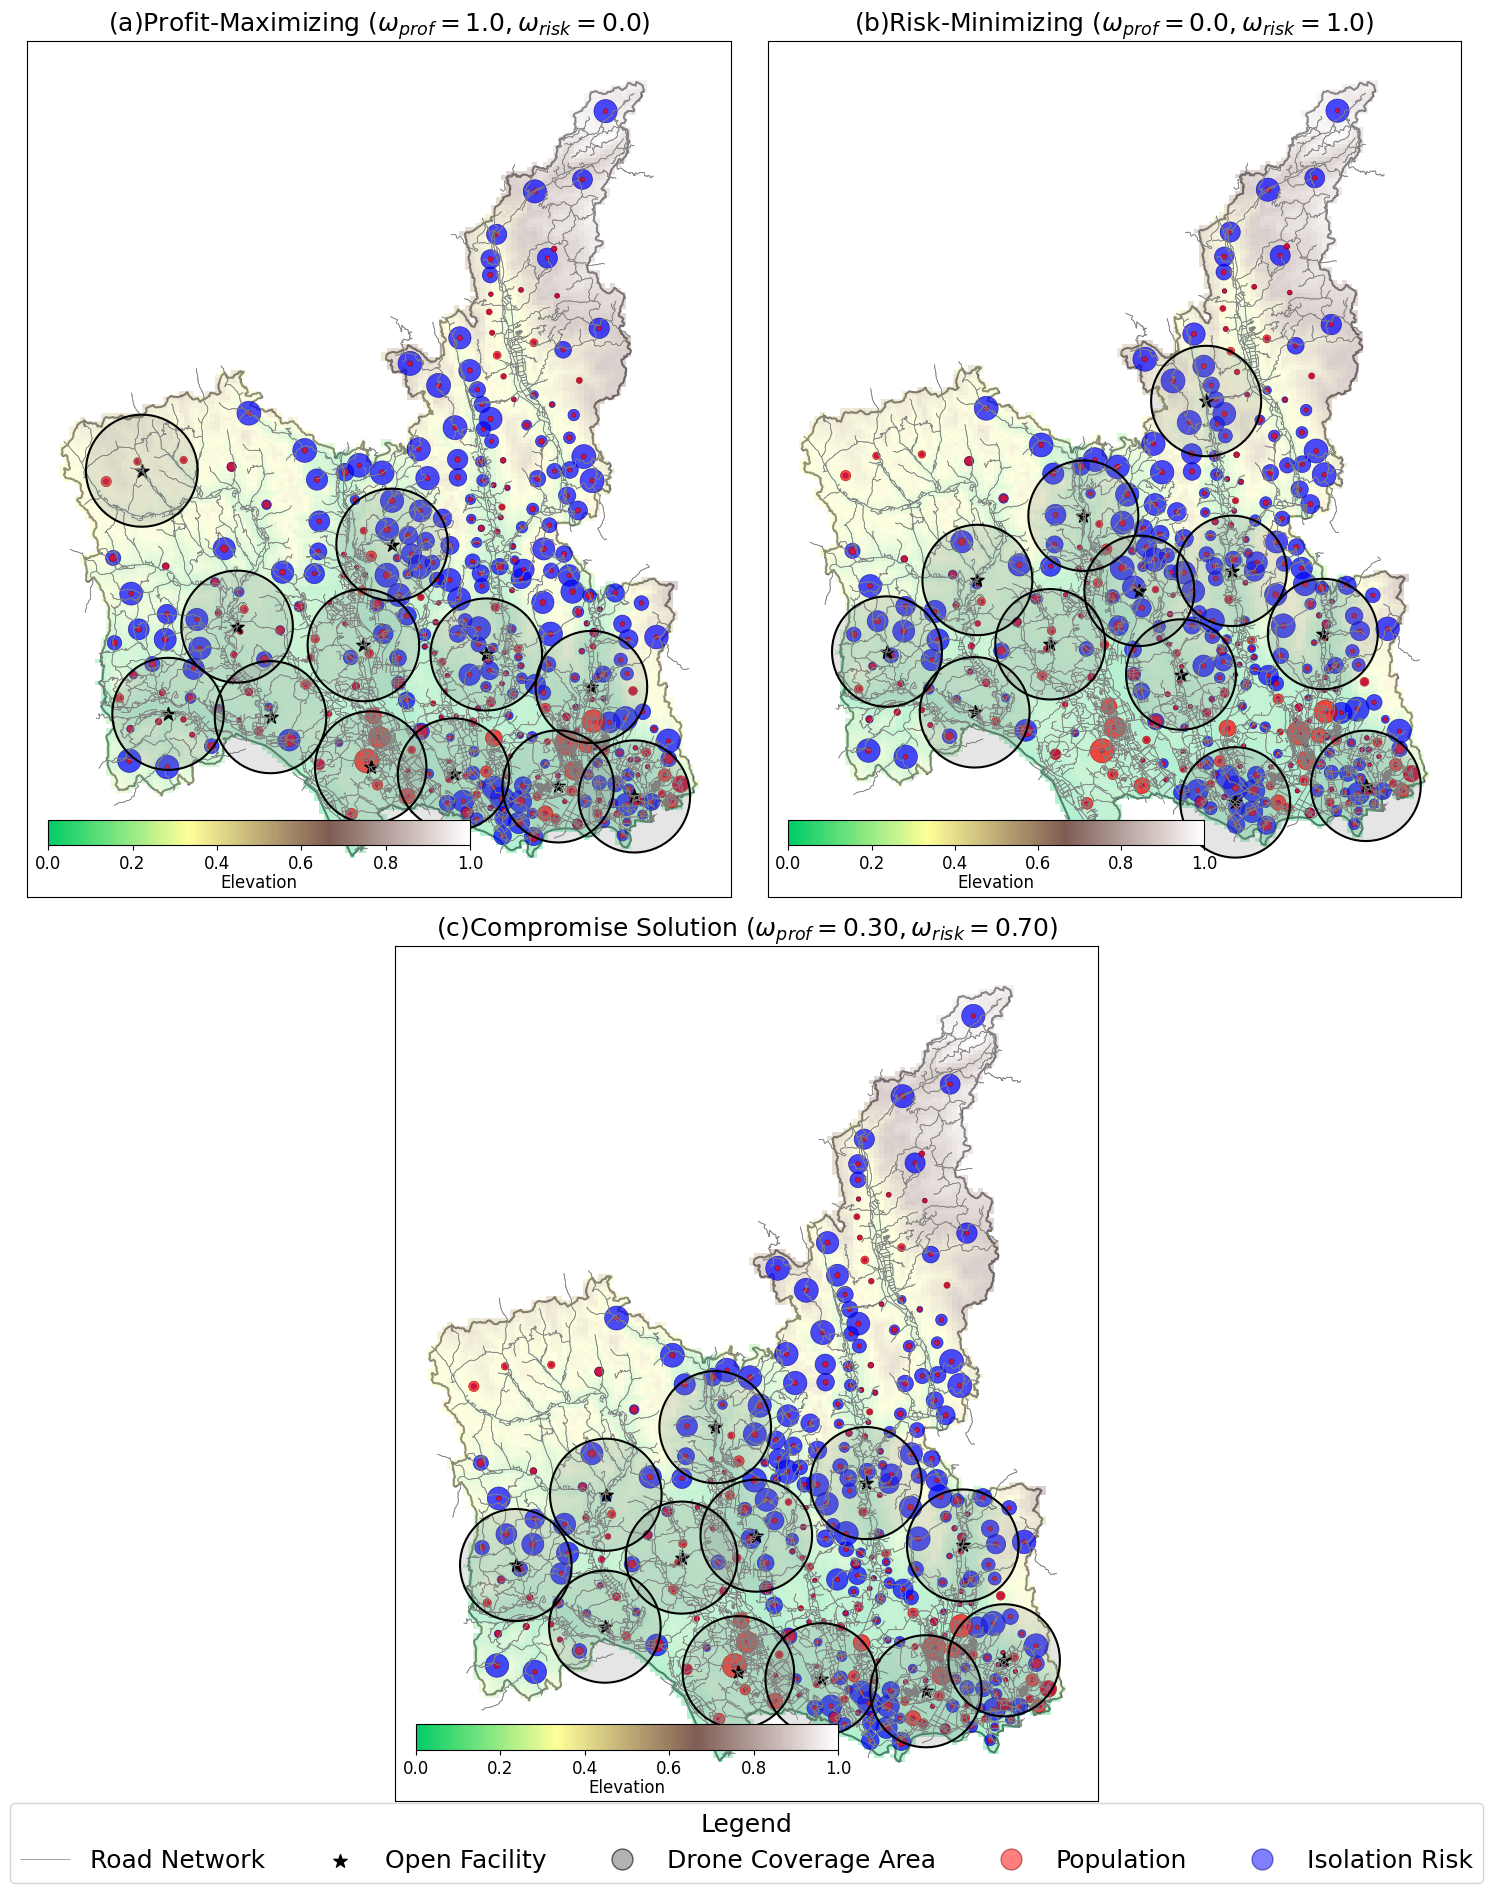

In [151]:
plot_comparison_maps_with_detailed_background(data['results_df'], data,font_size=18)


In [103]:
result_df_temp=data['results_df']
prof_omega_1=int(result_df_temp[result_df_temp['omega_profit'] == 1.00].loc[0,["total_profit"]])
risk_omega_1=int(result_df_temp[result_df_temp['omega_profit'] == 1.00].loc[0,["uncovered_risk"]])
prof_omega_0=int(result_df_temp[result_df_temp['omega_profit'] == 0.00].loc[14,["total_profit"]])
risk_omega_0=int(result_df_temp[result_df_temp['omega_profit'] == 0.00].loc[14,["uncovered_risk"]])
prof_omega_03=int(result_df_temp[result_df_temp['omega_profit'] == 0.30].loc[9,["total_profit"]])
risk_omega_03=int(result_df_temp[result_df_temp['omega_profit'] == 0.30].loc[9,["uncovered_risk"]])
print(f"Profit at omega_profit=1.0: {prof_omega_1}, Risk at omega_profit=1.0: {risk_omega_1}")
print(f"Profit at omega_profit=0.0: {prof_omega_0}, Risk at omega_profit=0.0: {risk_omega_0}")
print(f"Profit at omega_profit=0.3: {prof_omega_03}, Risk at omega_profit=0.3: {risk_omega_03}")
print(f"marginal_profit: {(prof_omega_1-prof_omega_03)/(prof_omega_1)}")
print(f"marginal_risk: {(risk_omega_1-risk_omega_03)/(risk_omega_1)}")



Profit at omega_profit=1.0: 260643866, Risk at omega_profit=1.0: 4056
Profit at omega_profit=0.0: 138555738, Risk at omega_profit=0.0: 2187
Profit at omega_profit=0.3: 246388103, Risk at omega_profit=0.3: 2457
marginal_profit: 0.05469441202963127
marginal_risk: 0.3942307692307692


/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/1363317880.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  prof_omega_1=int(result_df_temp[result_df_temp['omega_profit'] == 1.00].loc[0,["total_profit"]])
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/1363317880.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  risk_omega_1=int(result_df_temp[result_df_temp['omega_profit'] == 1.00].loc[0,["uncovered_risk"]])
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/1363317880.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  prof_omega_0=int(result_df_temp[result_df_temp['omega_profit'] == 0.00].loc[14,["total_profit"]])
/var/folders/dr/zxykd_7d3519k_l3xpcbr

# 感度分析の可視化

In [104]:
# ## 感度分析データの読み込み
SENSITIVITY_RESULTS_PKL = FINAL_OUTPUT_DIR + 'sensitivity_analysis_results.pkl'
try:
    sensitivity_data = pd.read_pickle(SENSITIVITY_RESULTS_PKL)
    logging.info(f"Successfully loaded sensitivity analysis data from {SENSITIVITY_RESULTS_PKL}")
except FileNotFoundError:
    logging.error(f"Sensitivity analysis results not found at {SENSITIVITY_RESULTS_PKL}")
    logging.error("Please run the sensitivity analysis script/notebook first.")
    sensitivity_data = None

In [105]:
def plot_grouped_pareto_frontiers(df: pd.DataFrame, param_col: str, base_params: dict, title: str, xlabel: str, ylabel: str):
    """
    指定されたパラメータごとにパレートフロンティアを重ねてプロットする。
    ωのラベルが重ならないように自動調整する。
    """
    fig, ax = plt.subplots(figsize=(14, 9))
    
    param_values = sorted(df[param_col].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(param_values)))
    
    max_risk = base_params['MAX_SUM_UNCOVERED_ISOLATED_PEOPLE']

    all_texts = []

    for i, p_val in enumerate(param_values):
        subset_df = df[df[param_col] == p_val].copy()
        subset_df['uncovered_risk'] = max_risk - subset_df['covered_risk']

        if 'omega_profit' not in subset_df.columns:
            logging.warning(f"'omega_profit' column not found for {param_col}={p_val}. Cannot sort by omega or annotate points.")
            plot_df = subset_df.sort_values('uncovered_risk').drop_duplicates(subset=['uncovered_risk', 'total_profit'])
        else:
            grouped = subset_df.groupby(['uncovered_risk', 'total_profit'])['omega_profit'].apply(list).reset_index()
            grouped['omega_profit'] = grouped['omega_profit'].apply(sorted)
            plot_df = grouped.sort_values(by='omega_profit', key=lambda s: s.apply(lambda l: l[0])).reset_index(drop=True)
        
        if param_col == 'n_f':
            label_prefix = r'$N_f$'
        elif param_col == 'l_drone':
            label_prefix = r'$L_{drone}$'
        else:
            label_prefix = param_col.replace("_", " ").title()
        
        ax.plot(
            plot_df['uncovered_risk'],
            plot_df['total_profit'],
            marker='o',
            markersize=6,
            linestyle='-',
            color=colors[i],
            label=f'{label_prefix} = {p_val}' # 👈 ここを修正
        )

        if 'omega_profit' in plot_df.columns:
            for _, row in plot_df.iterrows():
                risk_val = row['uncovered_risk']
                profit_val = row['total_profit']
                omega_list = row['omega_profit']

                if len(omega_list) == 1:
                    # 単一のomegaの場合
                    label_text = fr'$\omega_{{prof}}={omega_list[0]:.2f}$'
                else:
                    # 複数のomegaの場合
                    omega_values_str = ", ".join([f"{w:.2f}" for w in omega_list])
                    label_text = fr'$\omega_{{prof}} \in \{{{omega_values_str}\}}$'

                # ax.annotateの代わりに、textオブジェクトをリストに追加
                all_texts.append(ax.text(
                    x=risk_val, 
                    y=profit_val, 
                    s=label_text, 
                    fontsize=9, # フォントサイズを少し調整
                    color='black' # すべてのラベルを黒に統一して見やすくする
                ))

    # ループがすべて終わった後、テキストの位置をまとめて自動調整
    # arrowpropsで点とラベルを線で結ぶ
    adjust_text(
        all_texts,
        force_text=(0.5, 0.5),  # テキスト同士の反発力を上げる (x, y方向)
        expand_points=(1.5, 1.5), # 点とテキストの間の余白を広げる
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
    )

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    # ax.legend(title=param_col.replace("_", " ").title())
    if param_col == 'n_f':
        legend_title = fr'$N_f$'
    elif param_col == 'l_drone':
        legend_title = r'$L_{drone}$'
    else:
        legend_title = param_col.replace("_", " ").title()

    ax.legend(title=legend_title)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.show()

In [106]:

def analyze_and_plot_nf_efficiency(df: pd.DataFrame, base_params: dict):
    """各N_fにおける妥協解（膝）を特定し、投資効率（限界収益）をプロットする。"""
    logging.info("Analyzing and plotting marginal returns for N_f...")
    
    n_f_values = sorted(df['n_f'].unique())
    knee_points = []
    max_risk = base_params['MAX_SUM_UNCOVERED_ISOLATED_PEOPLE']

    for n_f in n_f_values:
        subset_df = df[df['n_f'] == n_f].copy()
        if subset_df.empty: continue
            
        _, knee_point_df = find_pareto_and_knee(subset_df, base_params)
        
        if knee_point_df is not None:
            knee_points.append({
                fr'n_f': n_f,
                'profit_at_knee': knee_point_df['total_profit'],
                'risk_reduction_at_knee': knee_point_df['covered_risk']
            })

    if not knee_points:
        logging.warning("Could not determine any knee points for efficiency analysis.")
        return

    efficiency_df = pd.DataFrame(knee_points)
    efficiency_df['profit_per_depot'] = efficiency_df['profit_at_knee'] / efficiency_df['n_f']
    efficiency_df['risk_reduction_per_depot'] = efficiency_df['risk_reduction_at_knee'] / efficiency_df['n_f']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=True)
    fig.suptitle('Analysis of Diminishing Marginal Returns at Compromise Solution', fontsize=16)

    ax1.plot(efficiency_df['n_f'], efficiency_df['profit_per_depot'], marker='o', color='royalblue')
    ax1.set_title('Profitability Efficiency', fontsize=14)
    ax1.set_ylabel('Average Profit per Depot [JPY]', fontsize=12)
    ax1.ticklabel_format(style='plain', axis='y')

    ax2.plot(efficiency_df['n_f'], efficiency_df['risk_reduction_per_depot'], marker='s', color='seagreen')
    ax2.set_title('Risk Reduction Efficiency', fontsize=14)
    ax2.set_ylabel('Average Risk Reduction per Depot', fontsize=12)
    
    for ax in (ax1, ax2):
        ax.set_xlabel('Number of Deployed Depots ($N_f$)', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xticks(n_f_values)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

In [107]:
def analyze_and_plot_ldrone_efficiency(df: pd.DataFrame, base_params: dict):
    """各L_droneにおける妥協解（膝）を特定し、投資効率をプロットする。"""
    logging.info("Analyzing and plotting efficiency for L_drone...")
    
    l_drone_values = sorted(df['l_drone'].unique())
    knee_points = []
    
    # この分析では施設数は固定されていると仮定
    num_open_facilities = base_params.get('NUM_OPEN_FACILITIES', 12)

    for l_drone in l_drone_values:
        subset_df = df[df['l_drone'] == l_drone].copy()
        if subset_df.empty: continue
            
        _, knee_point_df = find_pareto_and_knee(subset_df, base_params)
        
        if knee_point_df is not None:
            knee_points.append({
                'l_drone': l_drone,
                'profit_at_knee': knee_point_df['total_profit'],
                'risk_reduction_at_knee': knee_point_df['covered_risk']
            })

    if not knee_points:
        logging.warning("Could not determine any knee points for L_drone efficiency analysis.")
        return

    efficiency_df = pd.DataFrame(knee_points)
    
    # パフォーマンスをデポ数で割る
    efficiency_df['profit_per_depot'] = efficiency_df['profit_at_knee'] / num_open_facilities
    efficiency_df['risk_reduction_per_depot'] = efficiency_df['risk_reduction_at_knee'] / num_open_facilities

    # --- グラフ描画 ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=True)
    fig.suptitle(f'Performance at Compromise Solution (for N_f = {num_open_facilities})', fontsize=16)

    # 収益性の効率
    ax1.plot(efficiency_df['l_drone'], efficiency_df['profit_per_depot'], marker='o', color='royalblue')
    ax1.set_title('Profitability Efficiency', fontsize=14)
    ax1.set_ylabel('Average Profit per Depot [JPY]', fontsize=12)
    ax1.ticklabel_format(style='plain', axis='y')

    # リスク削減の効率
    ax2.plot(efficiency_df['l_drone'], efficiency_df['risk_reduction_per_depot'], marker='s', color='seagreen')
    ax2.set_title('Risk Reduction Efficiency', fontsize=14)
    ax2.set_ylabel('Average Risk Reduction per Depot', fontsize=12)
    
    for ax in (ax1, ax2):
        ax.set_xlabel('Drone Endurance ($L_{drone}$) [km]', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xticks(l_drone_values)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

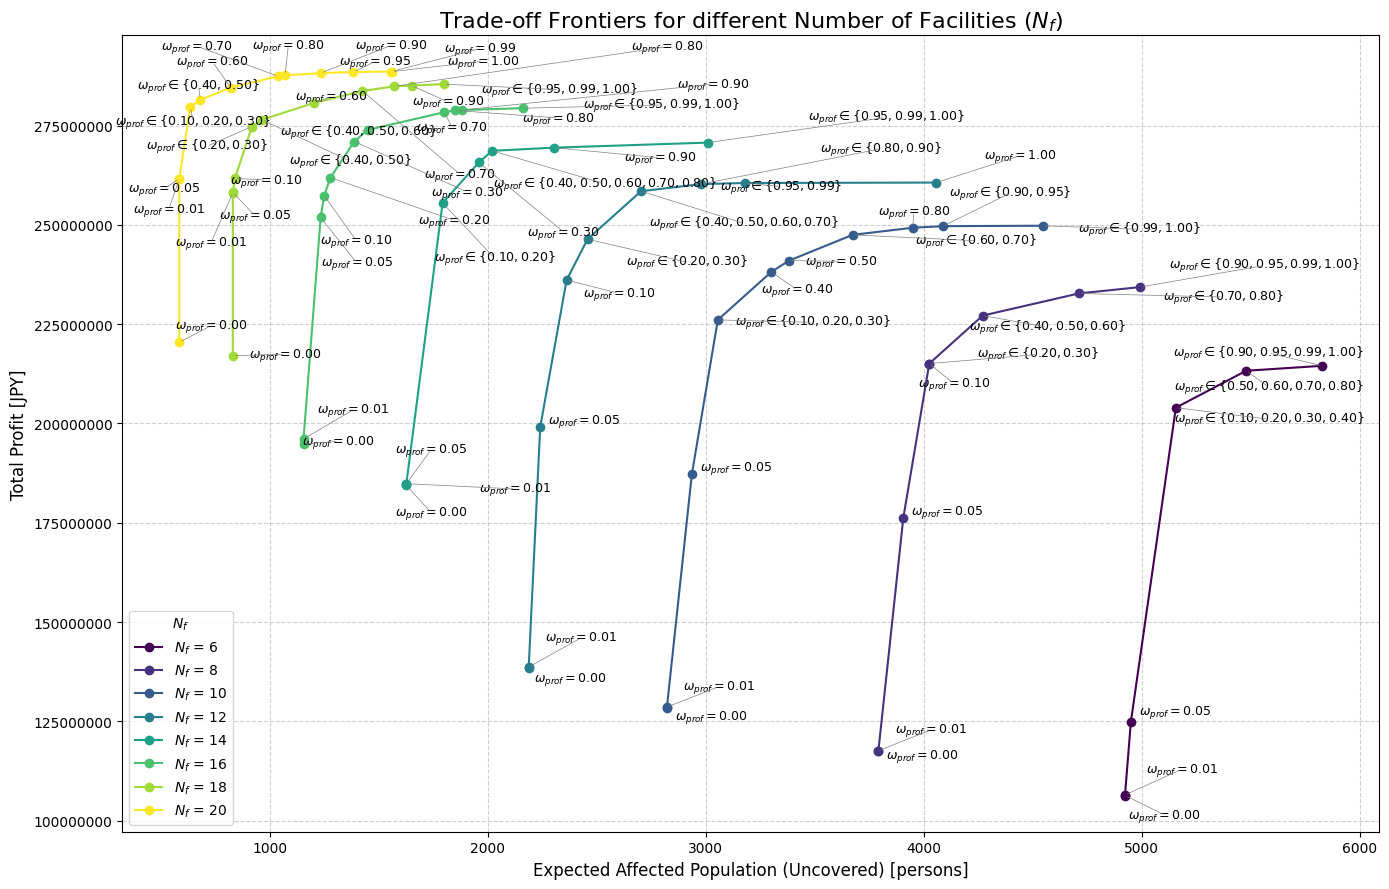

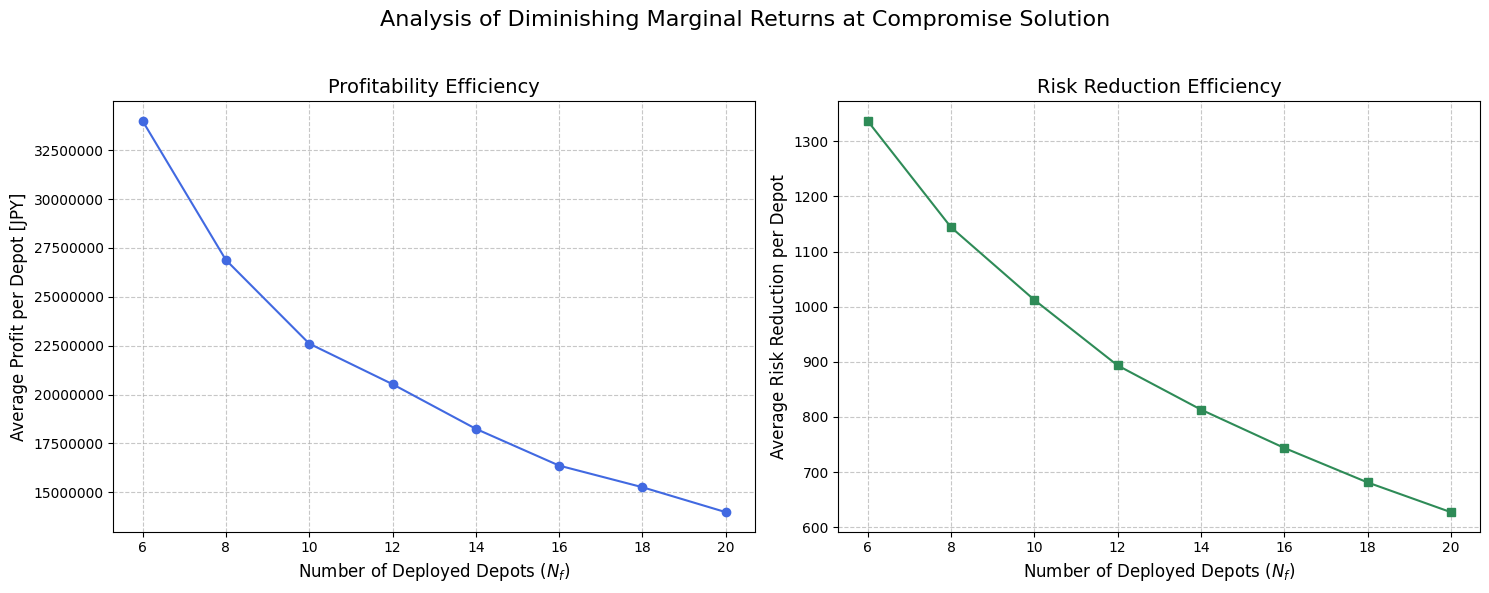

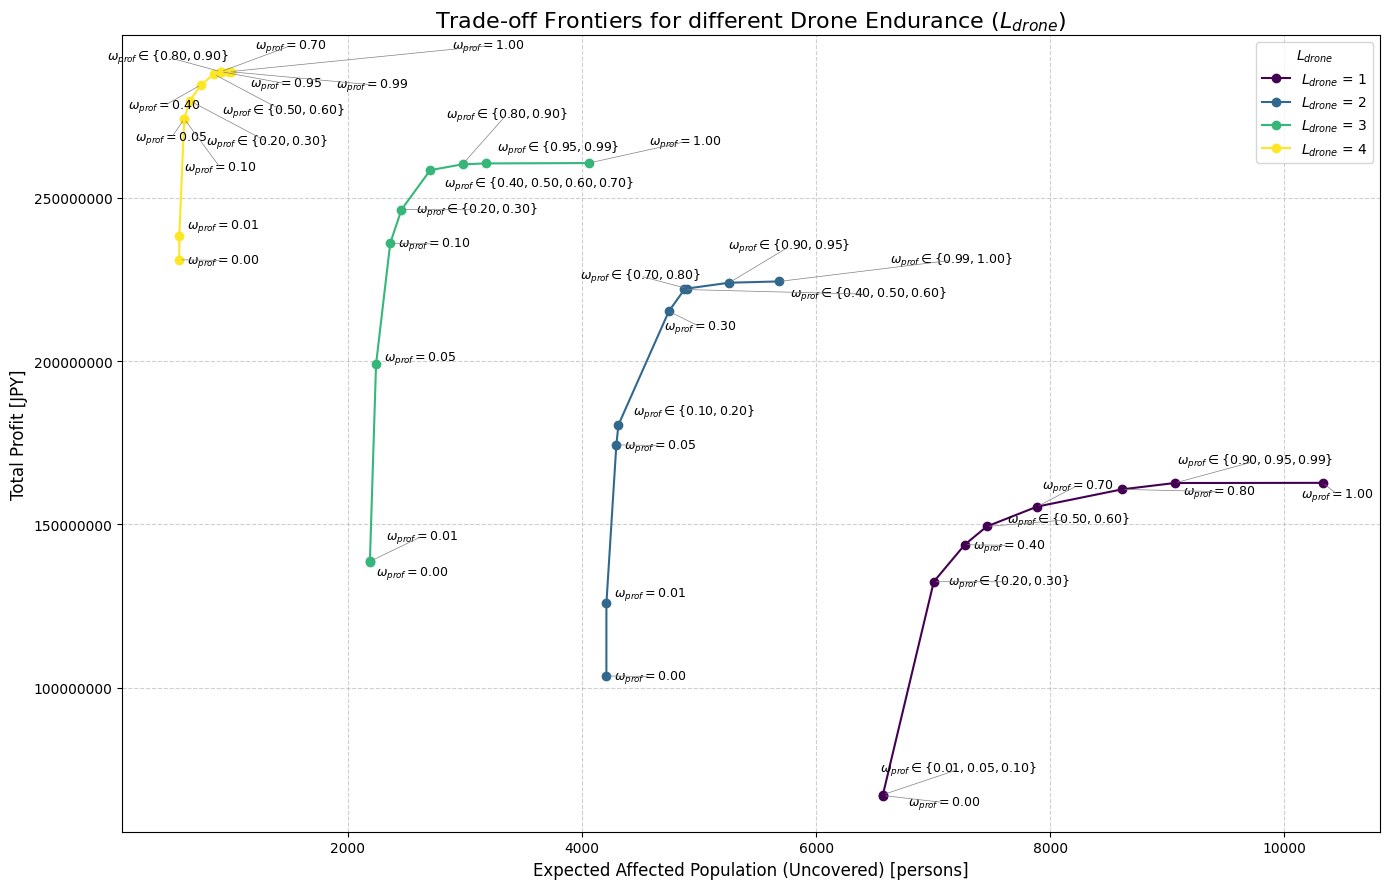

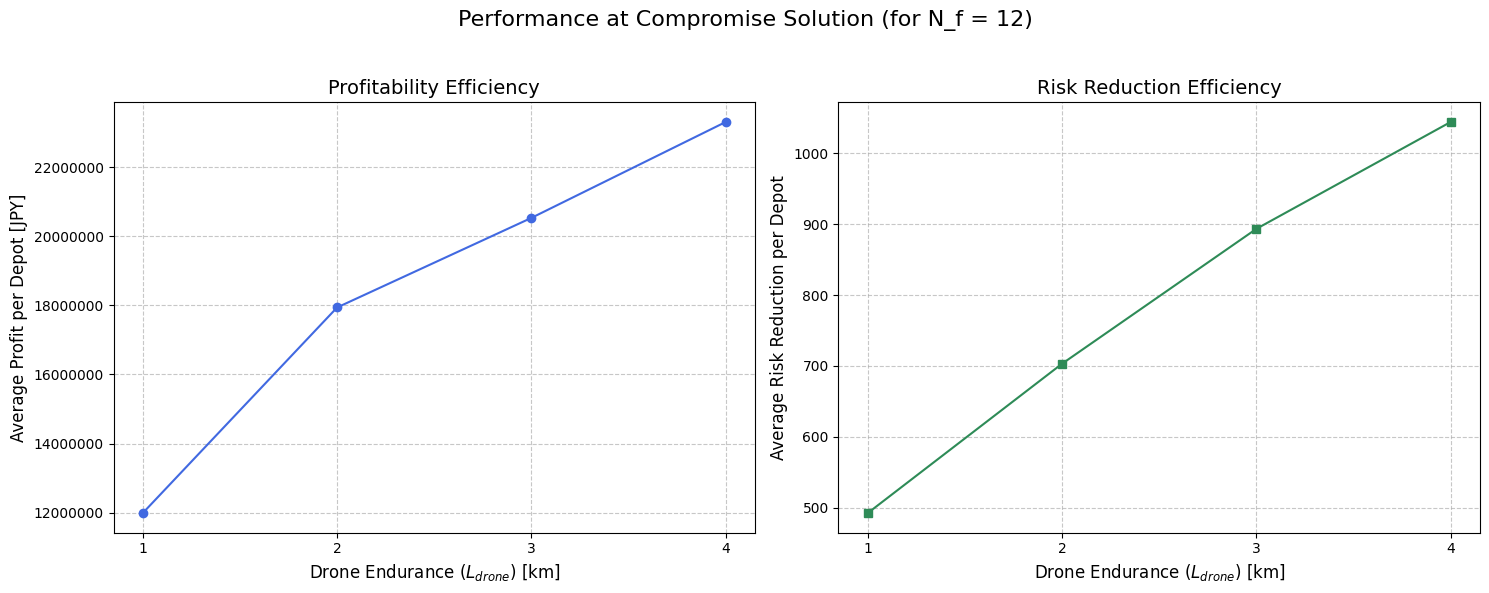

In [108]:
if sensitivity_data:
    df_nf = sensitivity_data.get('n_f_analysis')
    df_ldrone = sensitivity_data.get('l_drone_analysis')
    base_params = data['params']

    # 1. N_fの感度分析結果を可視化
    if df_nf is not None and not df_nf.empty:
        plot_grouped_pareto_frontiers(
            df=df_nf,
            param_col='n_f',
            base_params=base_params,
            title='Trade-off Frontiers for different Number of Facilities ($N_f$)',
            xlabel='Expected Affected Population (Uncovered) [persons]',
            ylabel='Total Profit [JPY]'
        )
        analyze_and_plot_nf_efficiency(df_nf, base_params)
    else:
        logging.warning("No data found for N_f sensitivity analysis.")

    # 2. L_droneの感度分析結果を可視化
    if df_ldrone is not None and not df_ldrone.empty:
        plot_grouped_pareto_frontiers(
            df=df_ldrone,
            param_col='l_drone',
            base_params=base_params,
            title='Trade-off Frontiers for different Drone Endurance ($L_{drone}$)',
            xlabel='Expected Affected Population (Uncovered) [persons]',
            ylabel='Total Profit [JPY]'
        )
        # ★★★ 追記: L_droneの効率性分析グラフも呼び出す ★★★
        analyze_and_plot_ldrone_efficiency(df_ldrone, base_params)
    else:
        logging.warning("No data found for L_drone sensitivity analysis.")

In [109]:
df_nf_6= sensitivity_data['n_f_analysis'][sensitivity_data['n_f_analysis']['n_f'] == 6]
df_nf_20= sensitivity_data['n_f_analysis'][sensitivity_data['n_f_analysis']['n_f'] == 20]
df_ldrone_1= sensitivity_data['l_drone_analysis'][sensitivity_data['l_drone_analysis']['l_drone'] == 1]
df_ldrone_4= sensitivity_data['l_drone_analysis'][sensitivity_data['l_drone_analysis']['l_drone'] == 4]

In [110]:
df_nf_6

status   obj_val                                             open_f  \
0   optimal  1.000000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1   optimal  0.998905  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2   optimal  0.994527  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3   optimal  0.989053  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4   optimal  0.981924  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
5   optimal  0.975765  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
6   optimal  0.969606  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7   optimal  0.963447  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
8   optimal  0.963401  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
9   optimal  0.965484  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
10  optimal  0.967568  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
11  optimal  0.969651  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
12  optimal  0.976017  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
13  optimal  0.994964  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
14  optimal  0.999999  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                              cover_d  \
0   [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1   [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2   [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3   [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4   [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
5   [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
6   [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7   [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
8   [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
9   [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
10  [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
11  [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
12  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...   
13  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
14  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                        connected_f_d  total_profit  \
0   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  2.145055e+08   
1   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  2.145055e+08   
2   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  2.145055e+08   
3   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  2.145055e+08   
4   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  2.132703e+08   
5   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  2.132703e+08   
6   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  2.132703e+08   
7   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  2.132703e+08   
8   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  2.039733e+08   
9   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  2.039733e+08   
10  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  2.039733e+08   
11  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  2.039733e+08   
12  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  1.249304e+08   
13  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  1.064800e+08   
14  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  1.063297e+08   

    covered_risk  omega_profit  omega_risk  n_f  
0    7352.337774          1.00        0.00    6  
1    7352.337774          0.99        0.01    6  
2    7352.337774          0.95        0.05    6  
3    7352.337774          0.90        0.10    6  
4    7700.093349          0.80        0.20    6  
5    7700.093349          0.70        0.30    6  
6    7700.093349          0.60        0.40    6  
7    7700.093349          0.50        0.50    6  
8    8022.759489          0.40        0.60    6  
9    8022.759489          0.30        0.70    6  
10   8022.759489          0.20        0.80    6  
11   8022.759489          0.10        0.90    6  
12   8229.154057          0.05        0.95    6  
13   8256.122221          0.01        

In [172]:
def plot_comparison_maps_with_detailed_background_nf(df_nf_6: pd.DataFrame, df_nf_20: pd.DataFrame, data: dict,font_size=22):
    """
    3つの主要シナリオを、詳細な背景地図上で比較プロットする。
    """
    logging.info("Plotting comparison maps with detailed background...")
    
    # シナリオの解を特定 (元のコードと同じ)
    def find_knee_and_compromise(results_df: pd.DataFrame, params: dict):      
        _, knee_point = find_pareto_and_knee(results_df, data['params'])
        # 膝の点に最も近い解を探す
        dist_to_knee = np.sqrt((results_df['uncovered_risk'] - knee_point['uncovered_risk'])**2 + (results_df['total_profit'] - knee_point['total_profit'])**2)
        compromise_sol = results_df.loc[dist_to_knee.idxmin()]
        return  knee_point, compromise_sol
    

    knee_point_nf_6, compromise_sol_nf_6 = find_knee_and_compromise(df_nf_6, data['params'])
    knee_point_nf_20, compromise_sol_nf_20 = find_knee_and_compromise(df_nf_20, data['params'])

    scenarios = {
        f'(a)$N_f = 6$ Compromise Solution ($\omega_{{prof}} = {knee_point_nf_6['omega_profit']:.2f}, \omega_{{risk}} = {knee_point_nf_6['omega_risk']:.2f}$)': compromise_sol_nf_6,
        f'(b)$N_f = 20$ Compromise Solution ($\omega_{{prof}} = {knee_point_nf_20['omega_profit']:.2f}, \omega_{{risk}} = {knee_point_nf_20['omega_risk']:.2f}$)': compromise_sol_nf_20
    }

    fig, axes = plt.subplots(1, 2, figsize=(14.5, 10), facecolor='white')
    # fig.suptitle('Optimal Depot Placement by Scenario', fontsize=24, y=0.98)

    # 【変更点】ループ内で背景と解を両方プロット
    for i, (ax, (title, solution)) in enumerate(zip(axes, scenarios.items())):
        plot_detailed_background_map(ax, data,font_size)

        # 2. 解をオーバーレイ
        plot_solution_overlay(ax, solution, data,font_size)
        ax.set_title(title, fontsize=font_size)
        
        # # 緯度・経度のラベルは端のプロットにのみ表示
        # if i > 0:
        #     ax.set_ylabel('')
        # else:
        #     ax.set_ylabel("Latitude", fontsize=22)
        # ax.set_xlabel("Longitude", fontsize=22)


     # 凡例の統合
    # 最初のサブプロットから基本凡例（道路、開設施設）を取得
    base_handles, base_labels = axes[0].get_legend_handles_labels()

    
    # 人口（赤丸）と孤立リスク（青丸）の凡例ハンドルを手動で作成
    from matplotlib.lines import Line2D
    pop_handle = Line2D([0], [0], marker='o', color='w', label='Population',
                          markerfacecolor='red', alpha=0.5, markersize=15, markeredgecolor='darkred')
    risk_handle = Line2D([0], [0], marker='o', color='w', label='Isolation Risk',
                           markerfacecolor='blue', alpha=0.5, markersize=15, markeredgecolor='darkblue')
    # ★★★ ドローンカバー範囲の凡例をPatchで作成 ★★★
    coverage_handle = Line2D([0], [0], marker='o', color='w', label='Drone Coverage Area',
                           markerfacecolor='gray', alpha=0.6, markersize=15, markeredgecolor='black')

    # すべての凡例要素を結合（順番を調整）
    # 順番: [道路, 開設施設, 人口, 孤立リスク]
    all_handles = base_handles + [coverage_handle, pop_handle, risk_handle]

    # 凡例をFigの外、下に配置 
    fig.legend(handles=all_handles, loc='lower center', ncol=5, fontsize=font_size, 
               bbox_to_anchor=(0.5, -0.00), frameon=True, title='Legend', title_fontsize=font_size)
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.93]) # rectで凡例スペースを確保
    plt.show()

<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/2704584626.py:20: SyntaxWarning: invalid escape sequence '\o'
  f'(a)$N_f = 6$ Compromise Solution ($\omega_{{prof}} = {knee_point_nf_6['omega_profit']:.2f}, \omega_{{risk}} = {knee_point_nf_6['omega_risk']:.2f}$)': compromise_sol_nf_6,
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/2704584626.py:20: SyntaxWarning: invalid escape sequence '\o'
  f'(a)$N_f = 6$ Compromise Solution ($\omega_{{prof}} = {knee_point_nf_6['omega_profit']:.2f}, \omega_{{risk}} = {knee_point_nf_6['omega_risk']:.2f}$)': compromis

/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/1824643310.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['uncovered_risk'] = max_risk - results_df['covered_risk']
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/1824643310.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['uncovered_risk'] = max_risk - results_df['covered_risk']
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/2156616506.py:52: UserWarning: Geometry is in a geogr

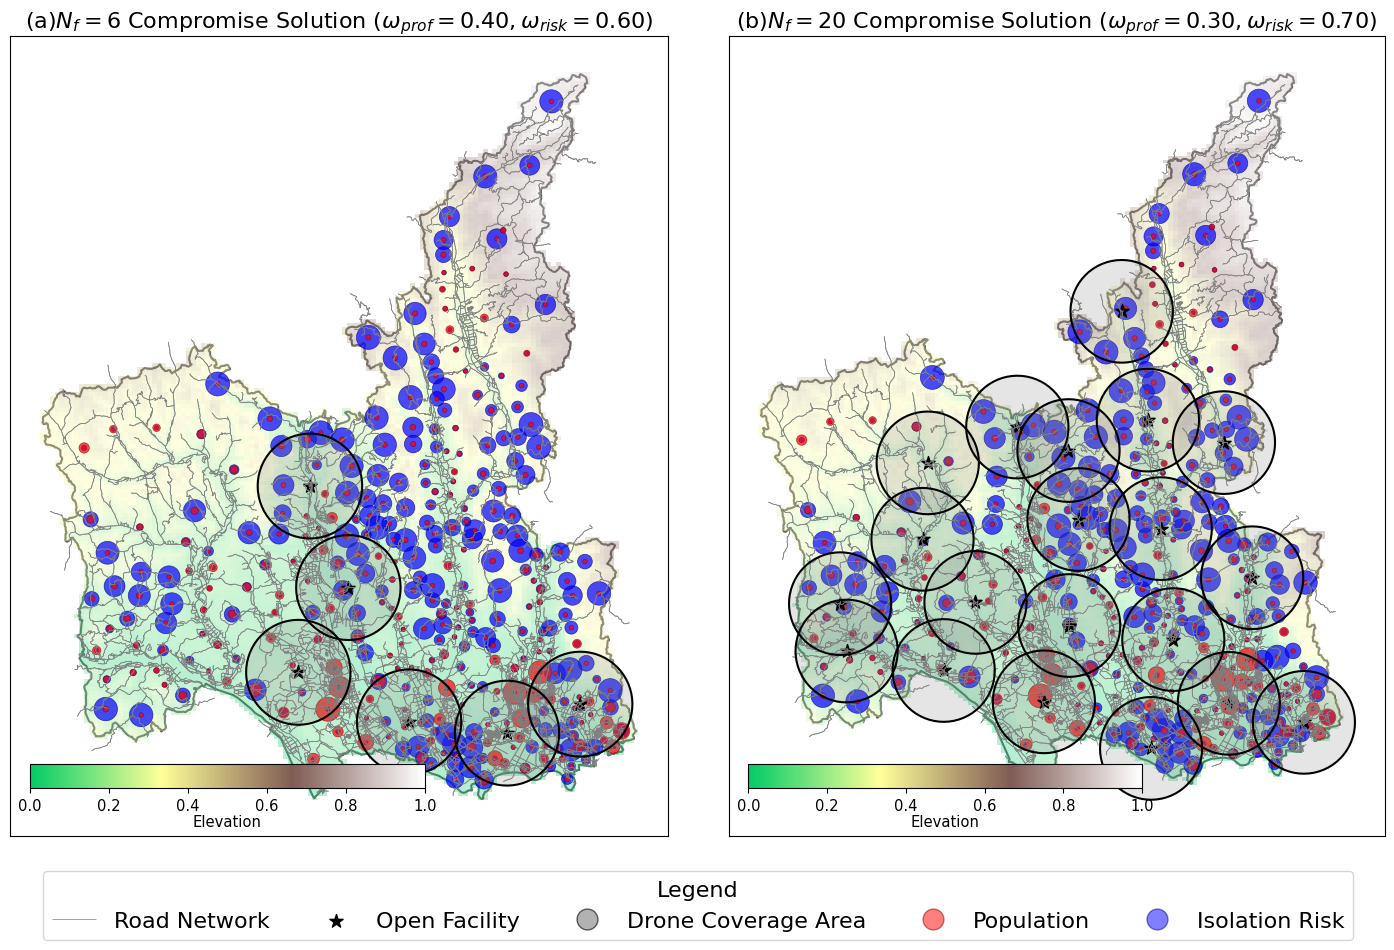

In [173]:
plot_comparison_maps_with_detailed_background_nf(df_nf_6, df_nf_20, data,font_size=16)


拠点がどのような特性の地域に配置されているかを可視化したい。

In [117]:
def check_covered_area_and_calculate_average(df_nf_6):
    temp_temp_df=find_pareto_and_knee(df_nf_6, data['params'])
    temp_gdf=data['facility'][temp_temp_df[1]["open_f"]==1]
    # 1. temp_gdfの各ポイントから半径3kmのバッファを作成
    #    CRSがメートル単位であるため、半径は3000とします。
    buffer_gdf = temp_gdf.copy()
    buffer_gdf['geometry'] = buffer_gdf.to_crs(temp_gdf.estimate_utm_crs()).geometry.buffer(3000).to_crs(temp_gdf.crs)

    # 重心を計算して、アクティブなジオメトリに設定
    centroids_gdf = syuraku_pop_risk_gdf.copy()
    centroids_gdf['centroid'] = centroids_gdf.geometry.centroid
    centroids_gdf = centroids_gdf.set_geometry('centroid')

    # 3. バッファと重心を空間的に結合（sjoin）
    #    'intersects'（交差する）条件で結合します。
    joined_gdf = gpd.sjoin(buffer_gdf, centroids_gdf, how="inner", predicate='intersects')

    # 4. 元のtemp_gdfのインデックスでグループ化し、平均値を計算
    #    'index_right' はsjoinによって付与される元のcentroids_gdfのインデックスを指します。
    #    ここではtemp_gdfのインデックス（joined_gdf.index）でグループ化します。
    result = joined_gdf.groupby(joined_gdf.index).agg({
        'expected_victims': 'mean',
        'total_population': 'mean'
    }).rename(columns={
        'expected_victims': 'avg_expected_victims',
        'total_population': 'avg_total_population'
    })

    # 5. 元のtemp_gdfに計算結果を結合
    final_gdf = temp_gdf.join(result)

    return final_gdf

In [118]:
final_gdf_n6=check_covered_area_and_calculate_average(df_nf_6)
final_gdf_n20=check_covered_area_and_calculate_average(df_nf_20)

/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/1824643310.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['uncovered_risk'] = max_risk - results_df['covered_risk']
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/1765736114.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_gdf['centroid'] = centroids_gdf.geometry.centroid
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/1824643310.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

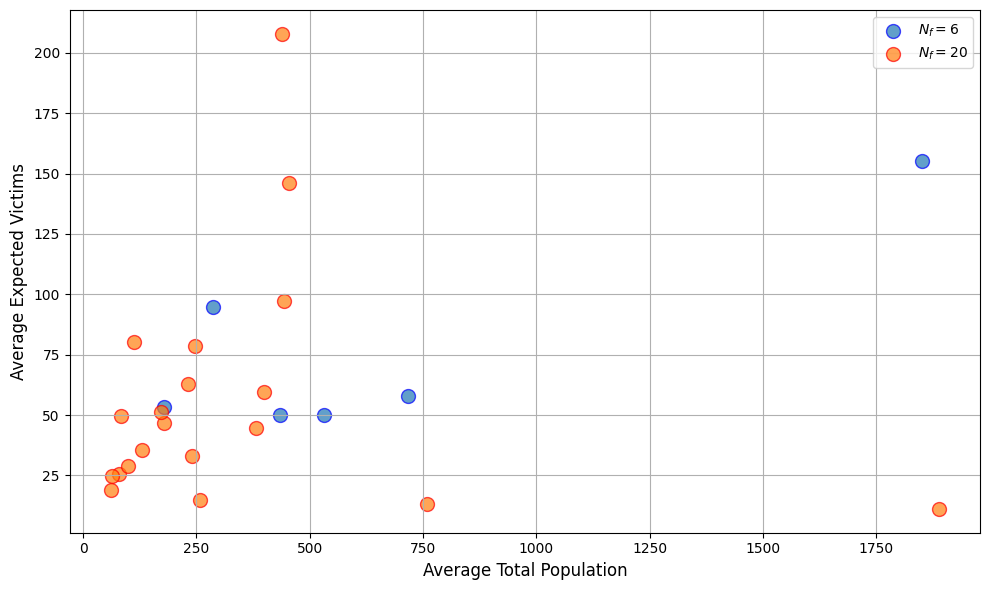

In [119]:
plt.figure(figsize=(10, 6))
plt.scatter(final_gdf_n6['avg_total_population'], final_gdf_n6['avg_expected_victims'], alpha=0.7, edgecolors='b', s=100, label=f'$N_f=6$')
plt.scatter(final_gdf_n20['avg_total_population'], final_gdf_n20['avg_expected_victims'], alpha=0.7, edgecolors='r', s=100, label=f'$N_f=20$')
plt.xlabel('Average Total Population', fontsize=12)
plt.ylabel('Average Expected Victims', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

In [192]:
def plot_solution_overlay_ldrone(ax, solution_row: pd.Series, data: dict,l_drone: int,fontsize):
    """
    単一の解（開設施設とカバー範囲）を既存の地図 (Axes) 上にオーバーレイしてプロットする。
    """
    # 【変更点】背景地図の描画コードを削除
    # data['syuraku_pop_risk_gdf'].plot(...) の行を削除しました

    # --- 施設とカバー範囲 ---
    facility_nodes = data['facility']
    open_facility_indices = np.where(solution_row['open_f'] == 1)[0]
    open_facilities = facility_nodes.iloc[open_facility_indices]
    
    if not open_facilities.empty:
        projected_crs = open_facilities.estimate_utm_crs()
        radius_m = l_drone * 1000
        coverage_areas = open_facilities.to_crs(projected_crs).buffer(radius_m).to_crs(facility_nodes.crs)
        # 1. 塗りつぶし部分だけを半透明でプロットします (枠線なし)
        coverage_areas.plot(ax=ax, facecolor='gray', alpha=0.2, edgecolor='none')

        # 2. その上から、境界線(edge)を不透明な黒線で重ねてプロットします
        #    linewidthを大きくすると、より太く濃い線になります
        coverage_areas.boundary.plot(ax=ax, color='black', linewidth=1.5)
        # 開設施設を最後にプロットして最前面に表示
        facility_nodes.iloc[open_facility_indices].plot(ax=ax, marker='*', color='black', markersize=100, edgecolor='black', label='Open Facility')

    ax.set_xticks([])
    ax.set_yticks([])

In [193]:
def plot_comparison_maps_with_detailed_background_ldrone(df_ldrone_1: pd.DataFrame, df_ldrone_4: pd.DataFrame, data: dict,fontsize):
    """
    3つの主要シナリオを、詳細な背景地図上で比較プロットする。
    """
    logging.info("Plotting comparison maps with detailed background...")
    
    # シナリオの解を特定 (元のコードと同じ)
    def find_knee_and_compromise(results_df: pd.DataFrame, params: dict):      
        _, knee_point = find_pareto_and_knee(results_df, data['params'])
        # 膝の点に最も近い解を探す
        dist_to_knee = np.sqrt((results_df['uncovered_risk'] - knee_point['uncovered_risk'])**2 + (results_df['total_profit'] - knee_point['total_profit'])**2)
        compromise_sol = results_df.loc[dist_to_knee.idxmin()]
        return  knee_point, compromise_sol
    

    knee_point_ldrone_1, compromise_sol_ldrone_1 = find_knee_and_compromise(df_ldrone_1, data['params'])
    knee_point_ldrone_4, compromise_sol_ldrone_4 = find_knee_and_compromise(df_ldrone_4, data['params'])

    scenarios = {
        f'(a)$L_{{drone}} = 1$ Compromise Solution ($\omega_{{prof}} = {knee_point_ldrone_1['omega_profit']:.2f}, \omega_{{risk}} = {knee_point_ldrone_1['omega_risk']:.2f}$)': compromise_sol_ldrone_1,
        f'(b)$L_{{drone}} = 4$ Compromise Solution ($\omega_{{prof}} = {knee_point_ldrone_4['omega_profit']:.2f}, \omega_{{risk}} = {knee_point_ldrone_4['omega_risk']:.2f}$)': compromise_sol_ldrone_4
    }

    fig, axes = plt.subplots(1, 2, figsize=(14.5, 10), facecolor='white')
    # fig.suptitle('Optimal Depot Placement by Scenario', fontsize=24, y=0.98)

    # 【変更点】ループ内で背景と解を両方プロット
    for i, (ax, (title, solution)) in enumerate(zip(axes, scenarios.items())):
        plot_detailed_background_map(ax, data,fontsize)

        # 2. 解をオーバーレイ
        plot_solution_overlay_ldrone(ax, solution, data, fontsize=fontsize, l_drone=solution['l_drone'])
        ax.set_title(title, fontsize=fontsize)
        
        # # 緯度・経度のラベルは端のプロットにのみ表示
        # if i > 0:
        #     ax.set_ylabel('')
        # else:
        #     ax.set_ylabel("Latitude", fontsize=22)
        # ax.set_xlabel("Longitude", fontsize=22)


     # 凡例の統合
    # 最初のサブプロットから基本凡例（道路、開設施設）を取得
    base_handles, base_labels = axes[0].get_legend_handles_labels()

    
    # 人口（赤丸）と孤立リスク（青丸）の凡例ハンドルを手動で作成
    from matplotlib.lines import Line2D
    pop_handle = Line2D([0], [0], marker='o', color='w', label='Population',
                          markerfacecolor='red', alpha=0.5, markersize=15, markeredgecolor='darkred')
    risk_handle = Line2D([0], [0], marker='o', color='w', label='Isolation Risk',
                           markerfacecolor='blue', alpha=0.5, markersize=15, markeredgecolor='darkblue')
    # ★★★ ドローンカバー範囲の凡例をPatchで作成 ★★★
    coverage_handle = Line2D([0], [0], marker='o', color='w', label='Drone Coverage Area',
                           markerfacecolor='gray', alpha=0.6, markersize=15, markeredgecolor='black')

    # すべての凡例要素を結合（順番を調整）
    # 順番: [道路, 開設施設, 人口, 孤立リスク]
    all_handles = base_handles + [coverage_handle, pop_handle, risk_handle]

    # 凡例をFigの外、下に配置 (ncolを5に増やすと見やすいかもしれません)
    fig.legend(handles=all_handles, loc='lower center', ncol=5, fontsize=fontsize, 
               bbox_to_anchor=(0.5, -0.00), frameon=True, title='Legend', title_fontsize=fontsize) # bbox_to_anchorのy値を調整
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.93]) # rectで凡例スペースを確保
    plt.show()

<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/754458787.py:20: SyntaxWarning: invalid escape sequence '\o'
  f'(a)$L_{{drone}} = 1$ Compromise Solution ($\omega_{{prof}} = {knee_point_ldrone_1['omega_profit']:.2f}, \omega_{{risk}} = {knee_point_ldrone_1['omega_risk']:.2f}$)': compromise_sol_ldrone_1,
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/754458787.py:20: SyntaxWarning: invalid escape sequence '\o'
  f'(a)$L_{{drone}} = 1$ Compromise Solution ($\omega_{{prof}} = {knee_point_ldrone_1['omega_profit']:.2f}, \omega_{{risk}} = {knee_point_ldrone_

/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/1824643310.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['uncovered_risk'] = max_risk - results_df['covered_risk']
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/1824643310.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['uncovered_risk'] = max_risk - results_df['covered_risk']
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_29244/2156616506.py:52: UserWarning: Geometry is in a geogr

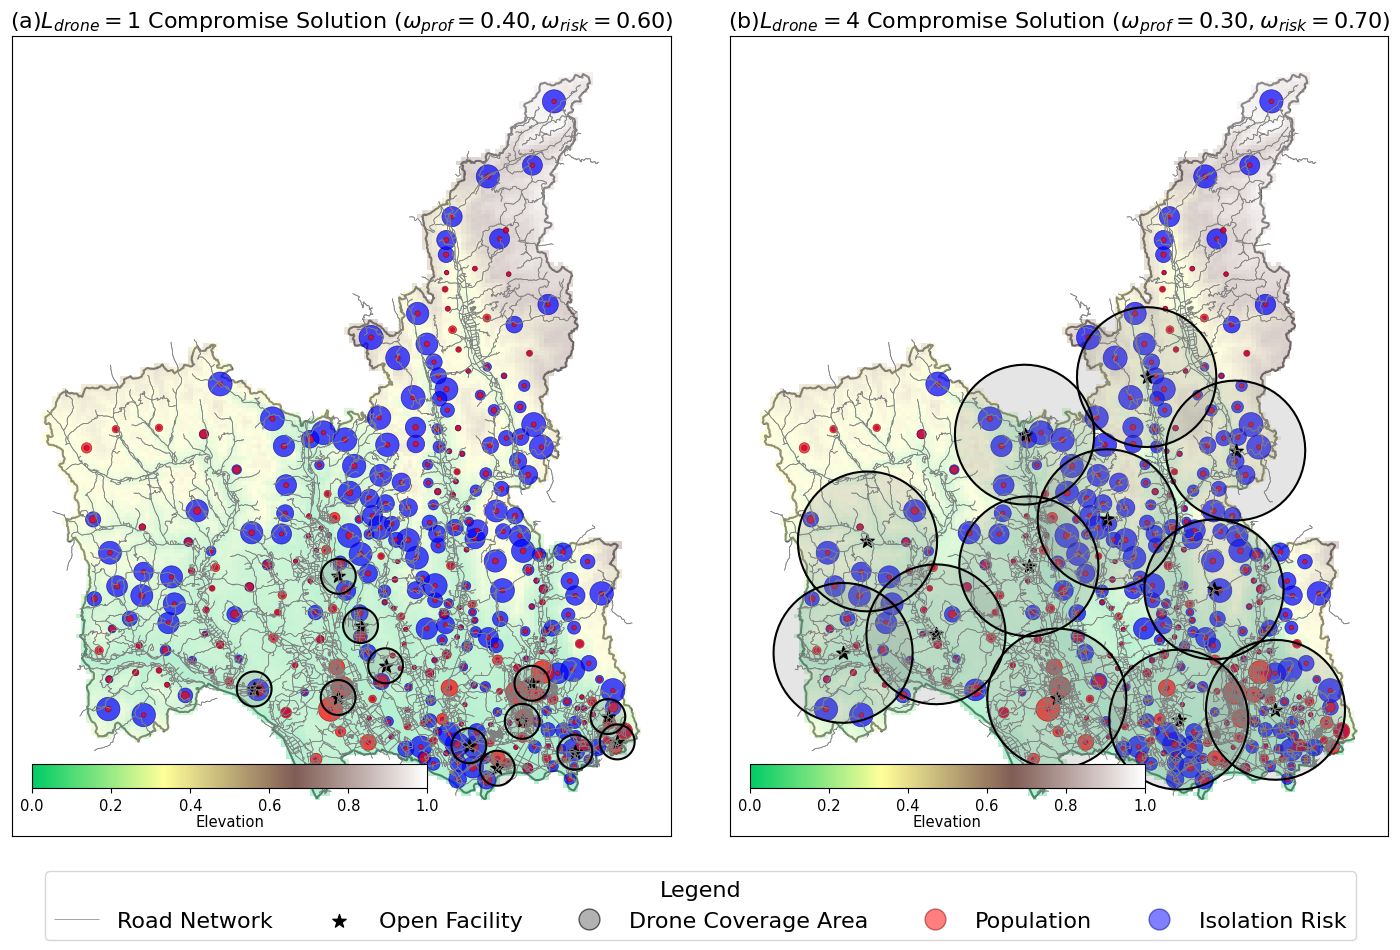

In [194]:
plot_comparison_maps_with_detailed_background_ldrone(df_ldrone_1, df_ldrone_4, data,fontsize=16)